In [1]:
import matplotlib.pyplot as plt
from Bio.SeqIO.FastaIO import SimpleFastaParser
import mmh3
import sys, time
from collections import Counter
import sys, itertools
import multiprocessing as mp

import numpy as np
import matplotlib.pyplot as plt
import imp, os, pickle, time, tables
import scipy.sparse as sp_sparse
from sklearn.metrics.pairwise import pairwise_distances
import seaborn as sns
import scipy.stats
import csv, argparse
import subprocess, shutil
from tqdm import tqdm, trange, tqdm_notebook, tnrange
from sklearn.metrics import roc_curve, auc


from scipy.stats import beta
%matplotlib inline

In [2]:
m = 10000
n = 1000

p = np.concatenate((beta.rvs(1,5, size = n), np.zeros((5,))))
q = np.random.rand(m)

In [4]:
EY = np.outer((0.5-p),(2*q-1) )  + 0.5

In [13]:
from scipy.stats import bernoulli

A = bernoulli.rvs(EY)
X = A - 0.5*1

In [14]:
budget = 500

In [15]:
x = np.ones((X.shape[1],))

In [16]:
b = np.ones((X.shape[0],))

In [17]:
def adaSH(X,budget, k):
    n,m = X.shape

    empReward = np.zeros(n)
    T = budget*n
    active = np.array(range(n))

    empReward = np.zeros(n)
    numPullsArr = np.zeros(n)
    numRounds = int(np.ceil(np.log2(n)))
    numPullsSoFar = 0
    
    ordering = np.random.permutation(m)
    
    for t in range(numRounds):
        numPulls = min(int(T/numRounds/len(active)),m)
        numPullsSoFar = min(numPullsSoFar+numPulls,m)

        mat_to_SVD = X[np.ix_(active,ordering[:numPullsSoFar])]
        U,Lambda,V = np.linalg.svd(mat_to_SVD)

        u0 = U[:,0]

        p_scale = (0.5/np.median(u0[-5:]))

        increment = -p_scale*u0 +0.5
        
        empReward[active] = increment
        numPullsArr[active]= numPullsSoFar

        thresh = np.median(empReward[active[:-5]])
        locs = np.where(empReward[active[:-5]]>thresh)
        active = np.concatenate((active[locs], np.arange(n-5,n)))

        if numPulls == m:
    #             print("max")
            break
        if len(active) <= 2*k+5:
            break

    return active[np.argsort(-empReward[active])[:2*k]],numPullsArr.mean()

In [18]:
def nonAdaSH(X,budget,k):
    n,m = X.shape
    
    sample_inds = np.random.choice(m,budget,replace=False)
    U,Lambda,V = np.linalg.svd(X[:,sample_inds])

    u0 = U[:,0]

    p_scale = (0.5/np.median(u0[-5:]))

    increment = -p_scale*u0 +0.5
    return np.argsort(-increment)[:2*k], budget

In [ ]:
hs = [10,30,90,270,810,2000,6000]
numTrials = 10000

unifSampling = np.zeros((len(hs),numTrials))
adaSampling = np.zeros((len(hs),numTrials))
adaBudget = np.zeros((len(hs), numTrials))
unifSampling_topK = np.zeros((len(hs),numTrials))
adaSampling_topK = np.zeros((len(hs),numTrials))

k = 5
updatedgtLocs = np.argsort(-p)[:k]

for i,h in tqdm_notebook(enumerate(hs), total=len(hs)):
    for t in tnrange(numTrials):
        
#         unifsamples, bud = nonAdaSH(X,h,k)
#         unifSampling[i,t] = np.mean([1.0*(x in unifsamples) for x in updatedgtLocs])
#         unifSampling_topK[i,t] = np.mean([1.0*(x in unifsamples[:k]) for x in updatedgtLocs])
        
        
        arr,budget = adaSH(X,h,k)
        adaSampling[i,t] = np.mean([1.0*(x in arr) for x in updatedgtLocs])
        adaSampling_topK[i,t] = np.mean([1.0*(x in arr[:k]) for x in updatedgtLocs])

        adaBudget[i,t]=budget

/home/tavorb/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/tavorb/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply
/home/tavorb/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/home/tavorb/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


In [466]:
adaSamplingStore = adaSampling
adaBudgetStore = adaBudget
unifSamplingStore = unifSampling

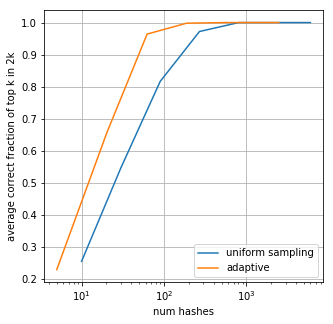

In [20]:
plt.figure(figsize=(5,5))
plt.plot(hs,unifSampling.mean(axis=1),label='uniform sampling')
plt.plot(adaBudget.mean(axis=1),adaSampling.mean(axis=1), label='adaptive')
plt.xscale('log')
plt.xlabel('num hashes')
plt.ylabel('average correct fraction of top k in 2k')
# plt.title('Top-k identification')
plt.legend()
plt.grid()
plt.savefig("")

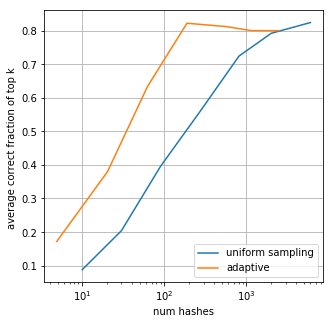

In [476]:
plt.figure(figsize=(5,5))
plt.plot(hs,unifSampling_topK.mean(axis=1),label='uniform sampling')
plt.plot(adaBudget.mean(axis=1),adaSampling_topK.mean(axis=1), label='adaptive')
plt.xscale('log')
plt.xlabel('num hashes')
plt.ylabel('average correct fraction of top k ')
# plt.title('Top-k identification')
plt.legend()
plt.grid()
plt.savefig("")

In [508]:
plt.rcParams['image.cmap']

'viridis'

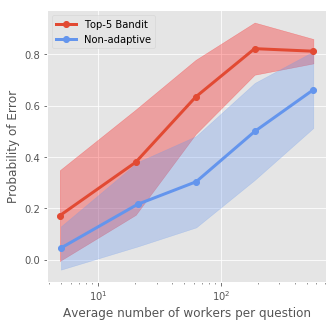

In [523]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.style.use('ggplot')
plt.xscale('log')


plt.plot(adaBudget.mean(axis=1)[:-2],adaSampling_topK.mean(axis=1)[:-2], "o-",label='Top-5 Bandit', linewidth=3)
ax.fill_between(adaBudget.mean(axis=1)[:-2], adaSampling_topK.mean(axis=1)[:-2] - adaSampling_topK.std(axis=1)[:-2], 
                adaSampling_topK.mean(axis=1)[:-2] + adaSampling_topK.std(axis=1)[:-2], color='red', alpha=0.3)

plt.plot(hnew,unifSampling_topK_new.mean(axis=1),"o-", color="cornflowerblue", label='Non-adaptive', linewidth=3)
ax.fill_between(hnew, unifSampling_topK_new.mean(axis=1) - unifSampling_topK_new.std(axis=1), 
                unifSampling_topK_new.mean(axis=1) + unifSampling_topK_new.std(axis=1), color="cornflowerblue", alpha=0.3)
plt.legend(loc=2)

plt.xlabel("Average number of workers per question")
plt.ylabel("Probability of Error")
plt.savefig("Crowdsourcing_topk.pdf")

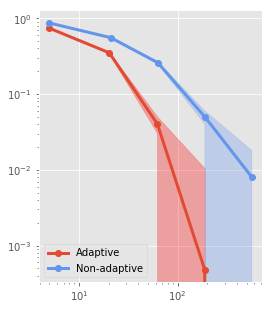

In [87]:
fig, ax = plt.subplots(figsize=(4, 5))

plt.style.use('ggplot')
plt.xscale('log')

numTrials = 10000


plt.plot(adaBudget.mean(axis=1)[:-2],1-adaSampling.mean(axis=1)[:-2], "o-", label='Adaptive', linewidth=3)
ax.fill_between(adaBudget.mean(axis=1)[:-2], (1-adaSampling.mean(axis=1)[:-2]) - numTrials**(-0.5), 
                (1-adaSampling.mean(axis=1)[:-2]) +numTrials**(-0.5), color='red', alpha=0.3)

plt.plot(hnew,1-unifSampling_new.mean(axis=1),"o-", color="cornflowerblue", label='Non-adaptive', linewidth=3)
ax.fill_between(hnew, (1-unifSampling_new.mean(axis=1)) - numTrials**(-0.5), 
                (1-unifSampling_new.mean(axis=1)) + numTrials**(-0.5), color="cornflowerblue", alpha=0.3)
plt.legend(loc=3)

plt.yscale("log")

# plt.xlabel("Average No. of Workers per Question")
# plt.ylabel("Probability of Success")

plt.savefig("Crowdsourcing_topk_2k_new.pdf")

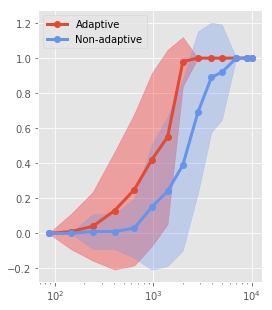

In [561]:
import pickle

ecoli_Data = pickle.load(open("maxSVD/ecoli_errorprob.p","rb"))

fig, ax = plt.subplots(figsize=(4, 5))

plt.style.use('ggplot')
plt.xscale('log')



plt.plot(ecoli_Data["x"],1-ecoli_Data["adaSampling"].mean(axis=1), "o-",label='Adaptive', linewidth=3)
ax.fill_between(ecoli_Data["x"],
                1-ecoli_Data["adaSampling"].mean(axis=1) - (1-ecoli_Data["adaSampling"]).std(axis=1), 
                1-ecoli_Data["adaSampling"].mean(axis=1) + (1-ecoli_Data["adaSampling"]).std(axis=1),
                color='red', alpha=0.3)

plt.plot(ecoli_Data["x"],1-ecoli_Data["unifSampling"].mean(axis=1),"o-", color="cornflowerblue", label='Non-adaptive', linewidth=3)
ax.fill_between(ecoli_Data["x"], 
                1-ecoli_Data["unifSampling"].mean(axis=1) - (1-ecoli_Data["unifSampling"]).std(axis=1), 
                1-ecoli_Data["unifSampling"].mean(axis=1) + (1-ecoli_Data["unifSampling"]).std(axis=1), 
                color="cornflowerblue", alpha=0.3)
plt.legend(loc=2)

# # plt.xlabel("Average No. of Workers per Question")
# # plt.ylabel("Probability of Success")

plt.savefig("ecoli_block_error_rate.pdf")

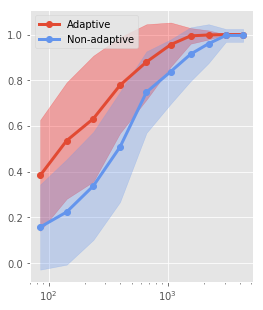

In [566]:
ecoli_Data = pickle.load(open("maxSVD/ecoli_2kmean.p","rb"))

fig, ax = plt.subplots(figsize=(4, 5))

plt.style.use('ggplot')
plt.xscale('log')



plt.plot(ecoli_Data["x"],ecoli_Data["adaSampling"].mean(axis=1), "o-",label='Adaptive', linewidth=3)
ax.fill_between(ecoli_Data["x"],
                ecoli_Data["adaSampling"].mean(axis=1) - (ecoli_Data["adaSampling"]).std(axis=1), 
                ecoli_Data["adaSampling"].mean(axis=1) + (ecoli_Data["adaSampling"]).std(axis=1),
                color='red', alpha=0.3)

plt.plot(ecoli_Data["x"],ecoli_Data["unifSampling"].mean(axis=1),"o-", color="cornflowerblue", label='Non-adaptive', linewidth=3)
ax.fill_between(ecoli_Data["x"], 
                ecoli_Data["unifSampling"].mean(axis=1) - (ecoli_Data["unifSampling"]).std(axis=1), 
                ecoli_Data["unifSampling"].mean(axis=1) + (ecoli_Data["unifSampling"]).std(axis=1), 
                color="cornflowerblue", alpha=0.3)
plt.legend(loc=2)

# # plt.xlabel("Average No. of Workers per Question")
# # plt.ylabel("Probability of Success")

plt.savefig("ecoli_top_2k.pdf")

In [83]:
hnew = np.array([   5,   21,   63,  189,
        566])

numTrials = 100
unifSampling_topK_new = np.zeros((len(hnew),numTrials))
unifSampling_new = np.zeros((len(hnew),numTrials))
for i,h in tqdm_notebook(enumerate(hnew), total=len(hnew)):
    for t in tnrange(numTrials):
        
        unifsamples, bud = nonAdaSH(X,h,k)
        unifSampling_new[i,t] = np.mean([1.0*(x in unifsamples) for x in updatedgtLocs])
        unifSampling_topK_new[i,t] = np.mean([1.0*(x in unifsamples[:k]) for x in updatedgtLocs])


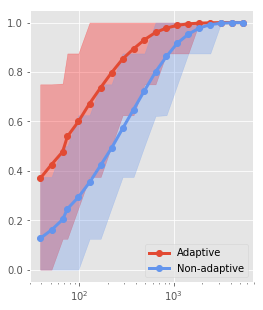

In [105]:
pctiles = 5
fig, ax = plt.subplots(figsize=(4,5))

adaBudget = NCTC_data["adaBudget"]

unifBudget = adaBudget

unifSampling = NCTC_data["unifSampling"]
adaSampling = NCTC_data["adaSampling"]

CIunif = np.percentile(unifSampling, [pctiles/2, 100-pctiles/2], axis=1)
CIada = np.percentile(adaSampling, [pctiles/2, 100-pctiles/2], axis=1)

plt.style.use('ggplot')
plt.grid()

# plt.plot(adaBudget,unifSampling.mean(axis=1),label='uniform sampling')
# plt.plot(adaBudget,adaSampling.mean(axis=1), label='adaptive')
_,numSims = adaSampling.shape

plt.plot(adaBudget,adaSampling.mean(axis=1), "o-",label='Adaptive', linewidth=3)
# ax.fill_between(adaBudget,
#                 [np.sort(adaSampling[i])[int(numSims*2.5//100)] for i in range(len(adaBudget))], 
#                 [np.sort(adaSampling[i])[int(numSims*97.5//100)] for i in range(len(adaBudget))],
#                 color='red', alpha=0.3)
ax.fill_between(adaBudget, CIada[0],CIada[1],
                color='red', alpha=0.3)

plt.plot(unifBudget,unifSampling.mean(axis=1),"o-", color="cornflowerblue", label='Non-adaptive', linewidth=3)
# ax.fill_between(unifBudget,
#                 [np.sort(unifSampling[i])[int(numSims*2.5//100)] for i in range(len(unifBudget))], 
#                 [np.sort(unifSampling[i])[int(numSims*97.5//100)] for i in range(len(unifBudget))],
#                 color='cornflowerblue', alpha=0.3)
ax.fill_between(unifBudget, CIunif[0],CIunif[1],
                color='cornflowerblue', alpha=0.3)
plt.legend(loc="lower right")


# CIunif = np.percentile(unifSampling, [2.5, 97.5], axis=1).T
# CIada = np.percentile(adaSampling, [2.5, 97.5], axis=1).T
# for i in range(len(adaBudget)):
# # for ConInt,x in zip(CI.T,adaBudget):
#     x = adaBudget[i]
#     plt.plot((x,x),(CIunif[i,0],CIunif[i,1]),'--', marker="_",color='cornflowerblue', alpha=0.4)
#     plt.plot((x,x),(CIada[i,0],CIada[i,1]),'--', marker="_",color='red', alpha=0.4)

plt.grid()
plt.xscale('log')
# plt.xlabel('Average number of hashes per read')
# plt.ylabel('Fraction of top k recovered')
# plt.title('Top-k alignment identification on ecoli')

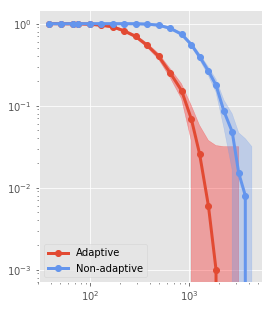

In [100]:
import pickle



NCTC_data = pickle.load(open("NCTC4174_maxSVD/plottingData.p","rb"))
# ecoli_Data = pickle.load(open("maxSVD/ecoli_errorprob_log_1extra.p","rb"))

fig, ax = plt.subplots(figsize=(4, 5))

plt.style.use('ggplot')
plt.xscale('log')

numTrials = 1000

plt.plot(NCTC_data["adaBudget"],NCTC_data["adaSampling"].mean(axis=1), "o-",label='Adaptive', linewidth=3)
ax.fill_between(NCTC_data["adaBudget"],
                NCTC_data["adaSampling"].mean(axis=1) - numTrials**(-0.5), 
                NCTC_data["adaSampling"].mean(axis=1) + numTrials**(-0.5),
                color='red', alpha=0.3)

plt.plot(NCTC_data["unifBudget"],NCTC_data["unifSampling"].mean(axis=1),"o-", color="cornflowerblue", label='Non-adaptive', linewidth=3)
ax.fill_between(NCTC_data["unifBudget"], 
                NCTC_data["unifSampling"].mean(axis=1) - numTrials**(-0.5), 
                NCTC_data["unifSampling"].mean(axis=1) + numTrials**(-0.5), 
                color="cornflowerblue", alpha=0.3)
plt.legend(loc=3)

# # plt.xlabel("Average No. of Workers per Question")
# # plt.ylabel("Probability of Success")
plt.yscale('log')
plt.savefig("NCTC_block_error_rate2.pdf")